# Preprocessing, Windowing and Calendar Features

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giulatona/iecon2025_tutorial/blob/main/notebooks/02_preprocessing_windowing_features.ipynb)

This notebook demonstrates preprocessing techniques for time series forecasting:

- **Data Preprocessing**: Cleaning, normalization, and scaling
- **Windowing Techniques**: Creating sliding windows for sequence modeling
- **Calendar Features**: Adding temporal features (to be used as exogenous features)

**Dataset**: UCI Individual Household Electric Power Consumption  
**Goal**: Prepare data for machine learning forecasting models

## Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

### Dataset Download (Hidden)
The following cell downloads the dataset if not available locally. This cell is hidden by default to keep the notebook clean.

In [4]:
# Download data if not available locally
import os
import urllib.request
import zipfile

# Check if running in Google Colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    print("Running in Google Colab - downloading dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip -q household_power_consumption.zip
    data_file = 'household_power_consumption.txt'
else:
    print("Running locally...")
    data_file = 'data/household_power_consumption.txt'
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Download dataset if it doesn't exist locally
    if not os.path.exists(data_file):
        print("Dataset not found locally. Downloading...")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
        zip_file = 'data/household_power_consumption.zip'
        
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('data/')
        
        print("Extraction completed.")
    else:
        print("Dataset found locally.")

print(f"Using data file: {data_file}")

Running locally...
Dataset found locally.
Using data file: data/household_power_consumption.txt


In [5]:
# Load and perform initial preprocessing
print("Loading dataset...")
df = pd.read_csv(data_file, sep=';', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")
df.head()

Loading dataset...
Dataset shape: (2075259, 9)
Date range: 16/12/2006 to 26/11/2010


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Preprocessing Pipeline

### 1. Basic Data Cleaning

In [6]:
def clean_data(df):
    """
    Clean the household power consumption dataset.
    
    Parameters:
    df (pd.DataFrame): Raw dataset
    
    Returns:
    pd.DataFrame: Cleaned dataset with datetime index
    """
    df_clean = df.copy()
    
    # Combine Date and Time columns
    df_clean['DateTime'] = pd.to_datetime(df_clean['Date'] + ' ' + df_clean['Time'], 
                                         format='%d/%m/%Y %H:%M:%S')
    
    # Replace '?' with NaN and convert to numeric
    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Set DateTime as index
    df_clean.set_index('DateTime', inplace=True)
    
    # Drop original Date and Time columns
    df_clean.drop(['Date', 'Time'], axis=1, inplace=True)
    
    return df_clean

# Apply cleaning
df_clean = clean_data(df)

### 1.1. Data Downsampling

The original dataset has 1-minute resolution, which results in a very large dataset. For this tutorial, we'll downsample to 15-minute intervals to reduce computational complexity while preserving the essential patterns.

In [7]:
def downsample_time_series(df, freq='15T', aggregation_method='mean'):
    """
    Downsample time series data to a lower frequency.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    freq (str): Target frequency (e.g., '15T' for 15 minutes, '1H' for 1 hour)
    aggregation_method (str): Method to aggregate values ('mean', 'sum', 'max', 'min')
    
    Returns:
    pd.DataFrame: Downsampled dataframe
    dict: Downsampling information
    """
    original_freq = pd.infer_freq(df.index)
    original_samples = len(df)
    
    # Apply downsampling based on aggregation method
    if aggregation_method == 'mean':
        df_downsampled = df.resample(freq).mean()
    elif aggregation_method == 'sum':
        df_downsampled = df.resample(freq).sum()
    elif aggregation_method == 'max':
        df_downsampled = df.resample(freq).max()
    elif aggregation_method == 'min':
        df_downsampled = df.resample(freq).min()
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")
    
    # Remove rows with all NaN values (can occur at the boundaries)
    df_downsampled = df_downsampled.dropna(how='all')
    
    return df_downsampled

In [8]:
# Apply downsampling to 15-minute intervals
print("Applying downsampling to 15-minute intervals...")

# Downsample the cleaned data
df_downsampled  = downsample_time_series(
    df_clean, 
    freq='15T',  # 15 minutes
    aggregation_method='mean'
)

# Use downsampled data for the rest of the preprocessing pipeline
df_clean = df_downsampled.copy()

print("✅ Downsampling completed. Using 15-minute interval data for further processing.")

Applying downsampling to 15-minute intervals...
✅ Downsampling completed. Using 15-minute interval data for further processing.


### 2. Missing Value Handling

#### Missing Value Strategy

The UCI Household Power Consumption dataset contains blocks of contiguous missing data rather than randomly scattered missing values. This pattern occurs when the monitoring system was temporarily offline or during data collection interruptions, creating gaps that can span several hours or even days.

Our approach leverages the strong seasonal patterns in household energy consumption data:

1. **Identify missing intervals** - Find continuous periods of missing data (>1 minute)
2. **Seasonal imputation** - Use previous years' data at the same time periods
3. **Weekly fallback** - If yearly data unavailable, use previous week's pattern
4. **Pattern preservation** - Maintains natural consumption patterns rather than simple interpolation

This method is particularly effective for energy data because:
- Households have consistent daily routines
- Seasonal patterns (heating/cooling) are predictable
- Weekly patterns (weekday vs weekend) are stable
- Historical data provides realistic consumption values
- Contiguous missing blocks preserve the temporal structure needed for sequence modeling

In [9]:
def fill_missing_values(dataset):
    """
    Fill missing values in time series data using seasonal patterns.
    
    This function identifies NaN intervals and fills them using:
    1. Previous years' data at the same time period (preferred)
    2. Previous week's data if yearly data is not available
    
    Parameters:
    dataset (pd.DataFrame): Input dataframe with datetime index and missing values
    
    Returns:
    pd.DataFrame: Dataframe with filled missing values
    """
    nan_intervals = []
    during_interval = False
    interval_start_index = None
    for dt, val in dataset.Global_active_power.items():
        if during_interval:
            if not np.isnan(val):
                timedelta = dt - interval_start_index
                if (timedelta) > pd.Timedelta(1, 'm'):
                    nan_intervals.append((interval_start_index, dt, timedelta))
                during_interval = False
        elif np.isnan(val):
            interval_start_index = dt
            during_interval = True

    def get_previous_years(timestamp, index):
        timestamp_list = []
        year_count = 1
        while (timestamp - pd.Timedelta(year_count * 365, 'd')) in index:
            timestamp_list.append(
                timestamp - pd.Timedelta(year_count * 365, 'd'))
            year_count = year_count + 1
        return timestamp_list

    def get_previous_week(timestamp, index):
        if (timestamp - pd.Timedelta(7, 'd')) in index:
            return timestamp - pd.Timedelta(7, 'd')
        else:
            return None

    nan_intervals = pd.DataFrame(nan_intervals, columns=[
                                 'start', 'stop', 'duration'])

    new_df = dataset.copy()
    for start, stop, _ in nan_intervals.itertuples(index=False):
        start_previous = get_previous_years(start, dataset.index)
        if start_previous:
            stop_previous = get_previous_years(stop, dataset.index)
            values = np.array([dataset.loc[t1: t2, :]
                              for t1, t2 in zip(start_previous, stop_previous)])
            new_df.loc[start: stop, :] = np.mean(values, axis=0)
        else:
            start_previous = get_previous_week(start, dataset.index)
            if start_previous:
                stop_previous = get_previous_week(stop, dataset.index)
                new_df.loc[start: stop,
                           :] = dataset.loc[start_previous: stop_previous, :].values

    return new_df

In [10]:
df_filled = fill_missing_values(df_clean)
print("✅ Missing values filled using seasonal patterns.")

✅ Missing values filled using seasonal patterns.


### 3. Data Normalization and Scaling

#### Normalization Methods

Feature normalization is crucial for time series forecasting models to ensure all features contribute equally during training and to improve convergence. We implement two commonly used normalization techniques:

**1. Standardization (Z-score normalization)**
- **Formula**: `(x - mean) / standard_deviation`
- **Result**: Mean = 0, Standard deviation = 1
- **Best for**: Neural networks, algorithms sensitive to feature scale
- **Preserves**: Outliers (maintains relative distances)
- **Use when**: Data follows normal distribution, outliers are meaningful

**2. Min-Max Scaling**
- **Formula**: `2 * (x - min) / (max - min) - 1`
- **Result**: Values scaled to [-1, 1] range
- **Best for**: When you need bounded values, comparing features with different units
- **Preserves**: Relative relationships between observations
- **Use when**: Data distribution is uniform, bounded output is required

**Key Considerations:**
- **Fit on training data**: Scaler parameters are computed only from training set
- **Transform consistently**: Apply same parameters to validation/test sets
- **Inverse transformation**: Essential for interpreting model predictions
- **Feature selection**: Automatically excludes binary indicators and cyclical features already in proper ranges

In [ ]:
def normalize_features(df, method='minmax', columns=None, scaler_params=None):
    """
    Normalize features using standardization or min-max scaling.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    method (str): 'standardize' or 'minmax'
    columns (list): Columns to normalize (None for all numeric)
    scaler_params (dict): Pre-computed scaler parameters (for transform mode)
    
    Returns:
    pd.DataFrame: Normalized dataframe
    dict: Scaler parameters for inverse transformation
    """
    df_norm = df.copy()
    
    # Determine columns to normalize
    if columns is None:
        # Select only numeric columns
        numeric_columns = df_norm.select_dtypes(include=[np.number]).columns.tolist()
        # Exclude datetime-related columns that shouldn't be normalized
        exclude_patterns = ['year', '_sin', '_cos', 'is_', 'days_', 'holiday_cluster', 'holidays_in_week']
        columns = [col for col in numeric_columns 
                  if not any(pattern in col.lower() for pattern in exclude_patterns)]
    
    # Initialize scaler parameters if not provided
    if scaler_params is None:
        scaler_params = {}
        fit_mode = True
    else:
        fit_mode = False
    
    for col in columns:
        if col not in df_norm.columns:
            continue
            
        if method == 'standardize':
            if fit_mode:
                mean_val = df_norm[col].mean()
                std_val = df_norm[col].std()
                scaler_params[col] = {'mean': mean_val, 'std': std_val, 'method': 'standardize'}
            else:
                mean_val = scaler_params[col]['mean']
                std_val = scaler_params[col]['std']
            
            # Z-score normalization: (x - mean) / std
            if std_val > 0:
                df_norm[col] = (df_norm[col] - mean_val) / std_val
            else:
                df_norm[col] = 0  # Handle constant columns
            
        elif method == 'minmax':
            if fit_mode:
                min_val = df_norm[col].min()
                max_val = df_norm[col].max()
                scaler_params[col] = {'min': min_val, 'max': max_val, 'method': 'minmax'}
            else:
                min_val = scaler_params[col]['min']
                max_val = scaler_params[col]['max']
            
            # Min-max normalization to [-1, 1]: 2 * (x - min) / (max - min) - 1
            range_val = max_val - min_val
            if range_val > 0:
                df_norm[col] = 2 * (df_norm[col] - min_val) / range_val - 1
            else:
                df_norm[col] = 0  # Handle constant columns
    
    return df_norm, scaler_params

def inverse_normalize_features(df_norm, scaler_params):
    """
    Inverse transform normalized features back to original scale.
    
    Parameters:
    df_norm (pd.DataFrame): Normalized dataframe
    scaler_params (dict): Scaler parameters from normalize_features
    
    Returns:
    pd.DataFrame: Features in original scale
    """
    df_orig = df_norm.copy()
    
    for col, params in scaler_params.items():
        if col not in df_orig.columns:
            continue
            
        method = params['method']
        
        if method == 'standardize':
            # Inverse z-score: x * std + mean
            df_orig[col] = df_orig[col] * params['std'] + params['mean']
            
        elif method == 'minmax':
            # Inverse min-max from [-1, 1]: (x + 1) * (max - min) / 2 + min
            range_val = params['max'] - params['min']
            df_orig[col] = (df_orig[col] + 1) * range_val / 2 + params['min']
    
    return df_orig

Normalization functions implemented.


Testing normalization methods...

--- STANDARDIZE NORMALIZATION ---
Global_active_power:
  Range: [-1.088, 3.959]
  Mean: -0.000, Std: 1.000
Voltage:
  Range: [-3.497, 2.160]
  Mean: -0.000, Std: 1.000
Global_intensity:
  Range: [-1.100, 4.118]
  Mean: 0.000, Std: 1.000

--- MINMAX NORMALIZATION ---
Global_active_power:
  Range: [-1.000, 1.000]
  Mean: -0.569, Std: 0.396
Voltage:
  Range: [-1.000, 1.000]
  Mean: 0.236, Std: 0.354
Global_intensity:
  Range: [-1.000, 1.000]
  Mean: -0.578, Std: 0.383


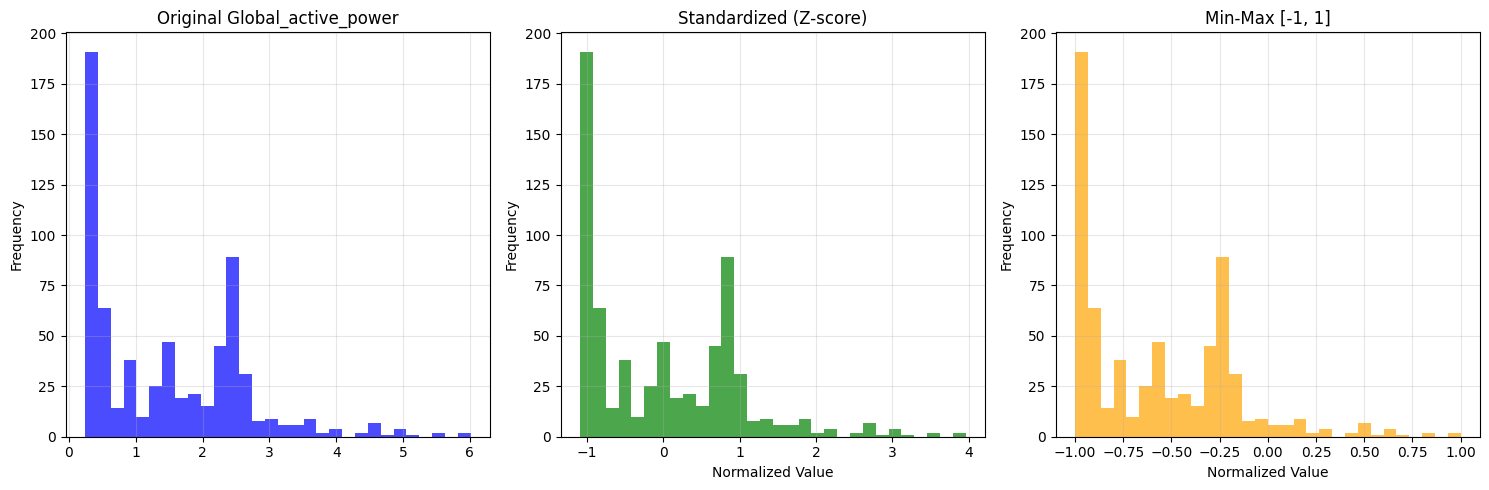


--- TESTING INVERSE TRANSFORMATION ---

standardize method:
  Global_active_power: Max difference = 8.88e-16 (should be ~0)
  Voltage: Max difference = 0.00e+00 (should be ~0)
  Global_intensity: Max difference = 3.55e-15 (should be ~0)

minmax method:
  Global_active_power: Max difference = 4.44e-16 (should be ~0)
  Voltage: Max difference = 0.00e+00 (should be ~0)
  Global_intensity: Max difference = 3.55e-15 (should be ~0)


In [13]:
# Example: Demonstrate normalization methods
print("Testing normalization methods...")

# Create a sample dataset for demonstration
sample_data = df_filled['2007-01-01':'2007-01-07'].copy()

# Test both normalization methods
methods = ['standardize', 'minmax']
results = {}

for method in methods:
    print(f"\n--- {method.upper()} NORMALIZATION ---")
    
    # Select specific columns for demonstration
    target_columns = ['Global_active_power', 'Voltage', 'Global_intensity']
    
    # Apply normalization
    normalized_data, scaler_params = normalize_features(
        sample_data, 
        method=method, 
        columns=target_columns
    )
    
    # Store results
    results[method] = {
        'data': normalized_data,
        'params': scaler_params
    }
    
    # Show statistics for each normalized column
    for col in target_columns:
        if col in normalized_data.columns:
            stats = normalized_data[col].describe()
            print(f"{col}:")
            print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
            print(f"  Mean: {stats['mean']:.3f}, Std: {stats['std']:.3f}")

# Visualize normalization effects
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data
col_to_plot = 'Global_active_power'
original_data = sample_data[col_to_plot].dropna()

axes[0].hist(original_data, bins=30, alpha=0.7, color='blue')
axes[0].set_title(f'Original {col_to_plot}')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Standardized (z-score)
standardized = results['standardize']['data'][col_to_plot].dropna()
axes[1].hist(standardized, bins=30, alpha=0.7, color='green')
axes[1].set_title(f'Standardized (Z-score)')
axes[1].set_xlabel('Normalized Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Min-Max [-1, 1]
minmax_01 = results['minmax']['data'][col_to_plot].dropna()
axes[2].hist(minmax_01, bins=30, alpha=0.7, color='orange')
axes[2].set_title(f'Min-Max [-1, 1]')
axes[2].set_xlabel('Normalized Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test inverse transformation
print("\n--- TESTING INVERSE TRANSFORMATION ---")
for method in methods:
    print(f"\n{method} method:")
    normalized_data = results[method]['data']
    scaler_params = results[method]['params']
    
    # Apply inverse transformation
    restored_data = inverse_normalize_features(normalized_data, scaler_params)
    
    # Compare original vs restored
    for col in target_columns:
        if col in sample_data.columns:
            original = sample_data[col].dropna()
            restored = restored_data[col].dropna()
            
            # Calculate difference (should be very small due to floating point precision)
            max_diff = abs(original - restored).max()
            print(f"  {col}: Max difference = {max_diff:.2e} (should be ~0)")

### 4. Dataset Splitting for Time Series

Time series data requires special consideration when splitting into train/validation/test sets to avoid data leakage and maintain temporal order.

#### Time Series Splitting Strategy

**Why ratios-based splitting?**

For time series data, we must preserve temporal order and avoid data leakage. The ratios method splits data chronologically:

- **Training set**: First portion of the time series (e.g., 70%)
- **Validation set**: Middle portion for model tuning (e.g., 15%) 
- **Test set**: Final portion for final evaluation (e.g., 15%)

**Key principles:**
- **Chronological order**: Earlier data for training, later data for testing
- **No shuffling**: Maintains temporal dependencies
- **No overlap**: Prevents future information leaking into past predictions
- **Representative splits**: Each set should cover sufficient time periods to capture patterns

**Common ratios:**
- **70/15/15**: Standard split for large datasets
- **80/10/10**: When you have abundant training data
- **60/20/20**: When you need more validation/test data

#### Important Considerations for Production Use

**⚠️ Tutorial Simplification Notice**

The splitting function above is simplified for tutorial purposes. In production time series forecasting, you must ensure that both validation and test sets contain **at least one full seasonality cycle** (e.g., one complete year for yearly patterns).

**Why seasonality matters:**

- **Pattern coverage**: Models need to see complete seasonal cycles to learn patterns properly
- **Robust evaluation**: Validation/test performance should reflect behavior across all seasons
- **Avoid bias**: Splitting mid-season can create artificially good/bad performance metrics
- **Real-world simulation**: Test sets should represent the full range of conditions the model will encounter

**Production recommendations:**

1. **Identify dominant seasonality**: For household energy data, this is typically yearly (heating/cooling cycles)
2. **Minimum validation period**: At least 1 full year (preferably 1.5-2 years for robust validation)
3. **Minimum test period**: At least 1 full year for reliable performance assessment
4. **Buffer periods**: Consider adding small gaps between train/val/test to simulate real deployment delays

**Example for multi-year data:**
```python
# For 4 years of data with yearly seasonality:
# Train: First 2 years (50%)
# Validation: Year 3 (25%) 
# Test: Year 4 (25%)
```

This ensures each split captures complete seasonal patterns and provides more reliable model evaluation.

In [14]:
def split_time_series_by_ratios(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split time series data chronologically using ratio-based approach.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    train_ratio (float): Proportion for training set (default: 0.7)
    val_ratio (float): Proportion for validation set (default: 0.15)  
    test_ratio (float): Proportion for test set (default: 0.15)
    
    Returns:
    tuple: (train_df, val_df, test_df) chronologically split dataframes
    dict: Split information with dates and sizes
    """
    # Validate ratios sum to 1.0
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError(f"Ratios must sum to 1.0, got {total_ratio}")
    
    # Ensure data is sorted by datetime index
    df_sorted = df.sort_index()
    total_samples = len(df_sorted)
    
    # Calculate split indices
    train_end_idx = int(total_samples * train_ratio)
    val_end_idx = int(total_samples * (train_ratio + val_ratio))
    
    # Split the data chronologically
    train_df = df_sorted.iloc[:train_end_idx].copy()
    val_df = df_sorted.iloc[train_end_idx:val_end_idx].copy()
    test_df = df_sorted.iloc[val_end_idx:].copy()
    
    # Create split information
    split_info = {
        'total_samples': total_samples,
        'train_samples': len(train_df),
        'val_samples': len(val_df), 
        'test_samples': len(test_df),
        'train_period': (train_df.index.min(), train_df.index.max()),
        'val_period': (val_df.index.min(), val_df.index.max()),
        'test_period': (test_df.index.min(), test_df.index.max()),
        'ratios_used': (train_ratio, val_ratio, test_ratio)
    }
    
    return train_df, val_df, test_df, split_info

def visualize_time_series_split(split_info, df=None):
    """
    Visualize the time series split to verify chronological order.
    
    Parameters:
    split_info (dict): Split information from split_time_series_by_ratios
    df (pd.DataFrame): Optional original dataframe for timeline visualization
    """
    print("=== TIME SERIES SPLIT SUMMARY ===")
    print(f"Total samples: {split_info['total_samples']:,}")
    print(f"Train samples: {split_info['train_samples']:,} ({split_info['train_samples']/split_info['total_samples']*100:.1f}%)")
    print(f"Val samples:   {split_info['val_samples']:,} ({split_info['val_samples']/split_info['total_samples']*100:.1f}%)")
    print(f"Test samples:  {split_info['test_samples']:,} ({split_info['test_samples']/split_info['total_samples']*100:.1f}%)")
    
    print(f"\n=== TIME PERIODS ===")
    print(f"Train period: {split_info['train_period'][0]} to {split_info['train_period'][1]}")
    print(f"Val period:   {split_info['val_period'][0]} to {split_info['val_period'][1]}")  
    print(f"Test period:  {split_info['test_period'][0]} to {split_info['test_period'][1]}")
    
    # Calculate period durations
    train_duration = split_info['train_period'][1] - split_info['train_period'][0]
    val_duration = split_info['val_period'][1] - split_info['val_period'][0]
    test_duration = split_info['test_period'][1] - split_info['test_period'][0]
    
    print(f"\n=== PERIOD DURATIONS ===")
    print(f"Train duration: {train_duration}")
    print(f"Val duration:   {val_duration}")
    print(f"Test duration:  {test_duration}")
    
    # Optional timeline visualization
    if df is not None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot a sample of the data to show timeline
        if 'Global_active_power' in df.columns:
            sample_data = df['Global_active_power'].dropna()
            ax.plot(sample_data.index, sample_data.values, alpha=0.7, linewidth=0.5, color='gray')
            
            # Add vertical lines to show split boundaries
            ax.axvline(split_info['train_period'][1], color='red', linestyle='--', 
                      label=f"Train/Val split", alpha=0.8)
            ax.axvline(split_info['val_period'][1], color='orange', linestyle='--', 
                      label=f"Val/Test split", alpha=0.8)
            
            # Color the background regions
            ax.axvspan(split_info['train_period'][0], split_info['train_period'][1], 
                      alpha=0.2, color='blue', label='Train')
            ax.axvspan(split_info['val_period'][0], split_info['val_period'][1], 
                      alpha=0.2, color='green', label='Validation')
            ax.axvspan(split_info['test_period'][0], split_info['test_period'][1], 
                      alpha=0.2, color='red', label='Test')
            
            ax.set_title('Time Series Split Visualization')
            ax.set_xlabel('Date')
            ax.set_ylabel('Global Active Power (kW)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


Demonstrating time series splitting...

=== EXAMPLE 1: Standard 70/15/15 Split ===
=== TIME SERIES SPLIT SUMMARY ===
Total samples: 136,639
Train samples: 95,647 (70.0%)
Val samples:   20,496 (15.0%)
Test samples:  20,496 (15.0%)

=== TIME PERIODS ===
Train period: 2006-12-16 17:15:00 to 2009-09-13 16:30:00
Val period:   2009-09-13 16:45:00 to 2010-04-18 18:00:00
Test period:  2010-04-18 18:15:00 to 2010-11-26 21:00:00

=== PERIOD DURATIONS ===
Train duration: 1001 days 23:15:00
Val duration:   217 days 01:15:00
Test duration:  222 days 02:45:00


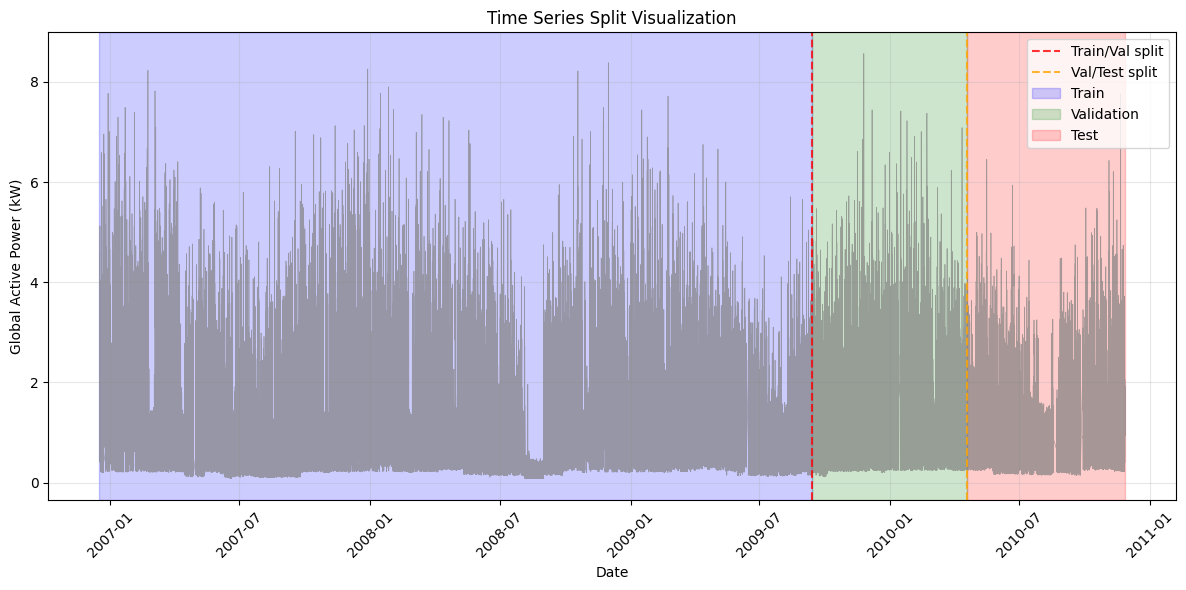

In [16]:
# Example: Demonstrate time series splitting
print("Demonstrating time series splitting...")

# Use the cleaned and filled dataset
df_for_splitting = df_filled.copy()

# Example 1: Standard 70/15/15 split
print("\n=== EXAMPLE 1: Standard 70/15/15 Split ===")
train_df, val_df, test_df, split_info = split_time_series_by_ratios(
    df_for_splitting, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    test_ratio=0.15
)

# Visualize the split
visualize_time_series_split(split_info, df_for_splitting)

## Windowing Techniques

### 1. Sliding Window Creation

In [17]:
def create_sliding_windows(data, window_size, forecast_horizon=1, step_size=1):
    """
    Create sliding windows for time series forecasting.
    
    Parameters:
    data (pd.DataFrame or np.array): Time series data
    window_size (int): Number of time steps in input window
    forecast_horizon (int): Number of time steps to predict
    step_size (int): Step size between windows
    
    Returns:
    tuple: (X, y) arrays for model training
    """
    # TODO: Implement sliding window creation
    # - Create input sequences (X) and target sequences (y)
    # - Handle multiple forecast horizons
    # - Support different step sizes
    # - Preserve temporal order
    pass


## Calendar Features Engineering

### 1. Fourier Features

#### Understanding Fourier Features

**What are Fourier Features?**

Fourier features use trigonometric functions (sine and cosine) to represent periodic patterns in time series data. They are based on the mathematical principle demonstrated by French mathematician Jean-Baptiste Fourier, who showed that **a series of sine and cosine terms of the right frequencies can approximate any periodic function**.

**Mathematical Foundation:**

If *m* is the seasonal period, then Fourier terms are given by:
- x₁,ₜ = sin(2πt/m), x₂,ₜ = cos(2πt/m)  
- x₃,ₜ = sin(4πt/m), x₄,ₜ = cos(4πt/m)
- x₅,ₜ = sin(6πt/m), x₆,ₜ = cos(6πt/m)
- and so on...

**Key Advantages:**

1. **Efficient representation**: With Fourier terms, we often need **fewer predictors than with dummy variables**, especially when *m* is large (e.g., weekly data where m≈52)

2. **Harmonic modeling**: The successive Fourier terms represent **harmonics** of the fundamental frequency, allowing capture of complex seasonal patterns

3. **Flexibility**: For short seasonal periods (e.g., quarterly data), Fourier terms give results **identical to seasonal dummy variables** when using the maximum number of terms

4. **Computational efficiency**: Particularly useful for high-frequency seasonality where traditional dummy variables would create too many features

**Harmonics Explained:**
- **k=1**: Fundamental frequency (basic seasonal cycle)
- **k=2**: Second harmonic (captures sub-patterns within the main cycle)  
- **k=3**: Third harmonic (captures even finer periodic details)

**Real-world Application:**
For household energy consumption, Fourier features can capture:
- Morning/evening usage peaks (daily patterns)
- Weekday vs weekend differences (weekly sub-patterns)
- Seasonal heating/cooling variations (yearly patterns)

**Reference:** This approach is extensively covered in [Section 7.4 of "Forecasting: Principles and Practice"](https://otexts.com/fpppy/nbs/07-regression.html#fourier-series), which demonstrates how Fourier series provide a powerful alternative to seasonal dummy variables for regression-based forecasting models.

In [18]:
def create_fourier_features(dataset, num_fourier_terms=3):
    """
    Create Fourier terms for daily and yearly cycles.
    
    Fourier features capture periodic patterns more effectively than simple
    cyclical encoding by using multiple harmonics.
    
    Parameters:
    dataset (pd.DataFrame): Input dataframe with datetime index
    num_fourier_terms (int): Number of Fourier terms to generate
    
    Returns:
    pd.DataFrame: Dataframe with added Fourier features
    list: List of column names that were added
    """
    dataset = dataset.copy()
    used_columns = []
    
    # Convert datetime index to timestamp in seconds
    timestamp_s = dataset.index.astype('int64') // 10**9
    
    # Define time periods in seconds
    day = 24*60*60
    year = (365.2425)*day

    for k in range(1, num_fourier_terms + 1):
        # Daily Fourier terms
        prefix = 'Day'
        col_name = prefix + f" sin{k}"
        dataset[col_name] = np.sin(timestamp_s * (2 * k * np.pi / day))
        used_columns.append(col_name)

        col_name = prefix + f" cos{k}"
        dataset[col_name] = np.cos(timestamp_s * (2 * k * np.pi / day))
        used_columns.append(col_name)

        # Yearly Fourier terms
        prefix = 'Year'
        col_name = prefix + f" sin{k}"
        dataset[col_name] = np.sin(timestamp_s * (2 * k * np.pi / year))
        used_columns.append(col_name)

        col_name = prefix + f" cos{k}"
        dataset[col_name] = np.cos(timestamp_s * (2 * k * np.pi / year))
        used_columns.append(col_name)
    
    return dataset, used_columns

Creating Fourier features...
Added 12 Fourier features:
['Day sin1', 'Day cos1', 'Year sin1', 'Year cos1', 'Day sin2', 'Day cos2', 'Year sin2', 'Year cos2', 'Day sin3', 'Day cos3', 'Year sin3', 'Year cos3']


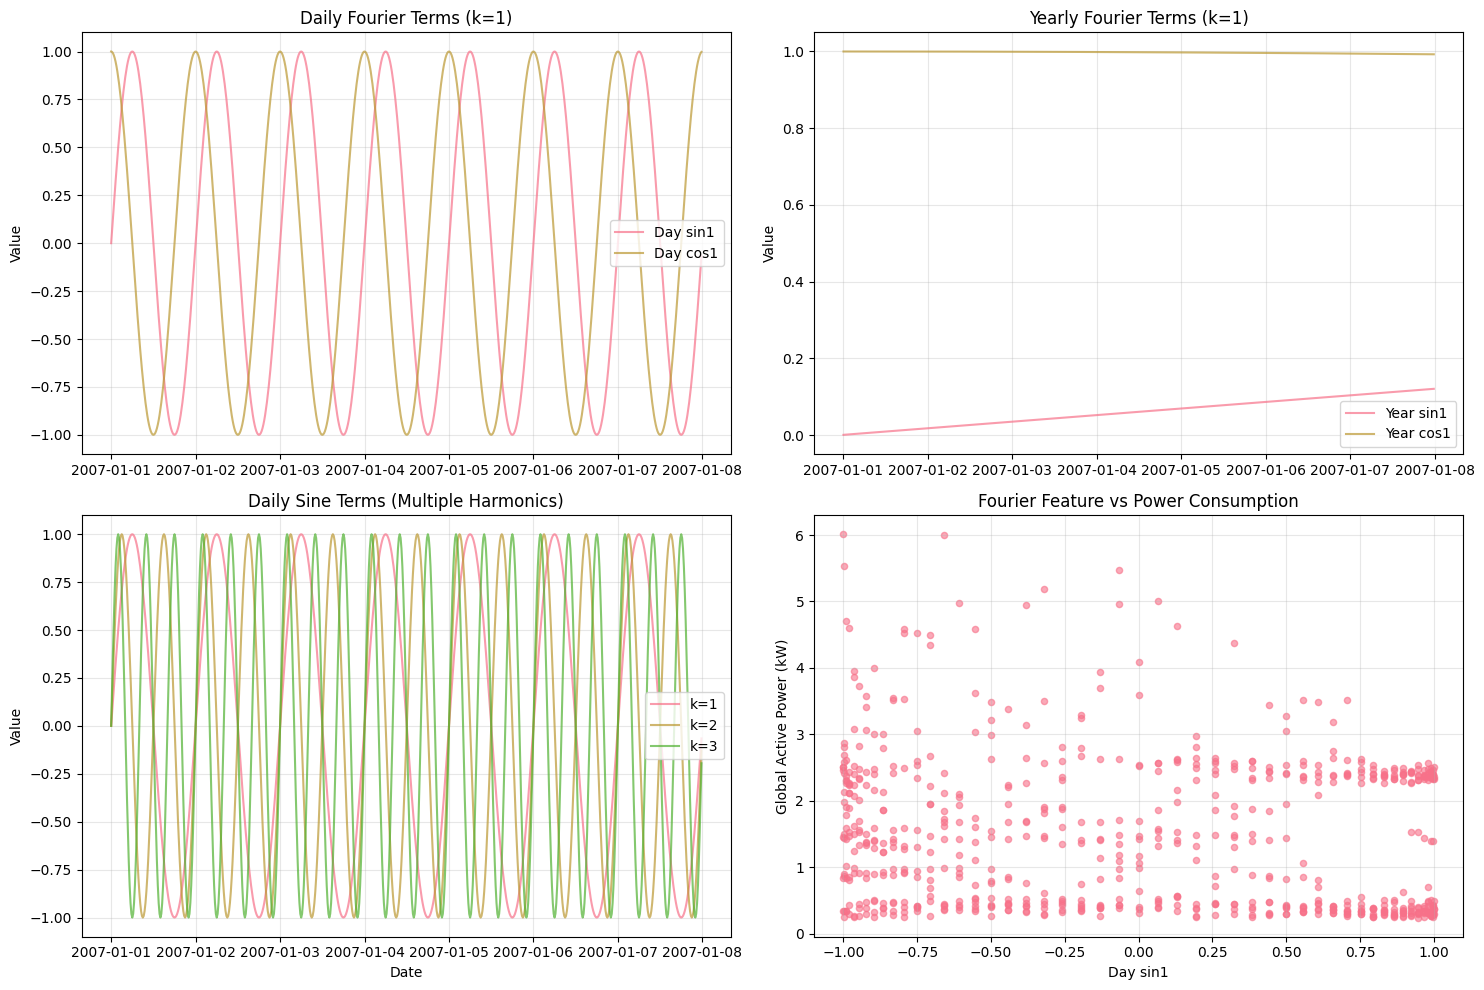


Dataset shape after adding Fourier features: (136639, 19)
Original shape: (136639, 7)


In [ ]:
# Example: Create and visualize Fourier features
print("Creating Fourier features...")

# Create Fourier features
df_fourier, fourier_columns = create_fourier_features(df_filled, num_fourier_terms=3)

print(f"Added {len(fourier_columns)} Fourier features:")
print(fourier_columns)

# Plot the Fourier features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sample a week for visualization
sample_start = '2007-01-01'
sample_end = '2007-01-07'
df_sample = df_fourier[sample_start:sample_end]

# Plot daily Fourier terms
axes[0, 0].plot(df_sample.index, df_sample['Day sin1'], label='Day sin1', alpha=0.7)
axes[0, 0].plot(df_sample.index, df_sample['Day cos1'], label='Day cos1', alpha=0.7)
axes[0, 0].set_title('Daily Fourier Terms (k=1)')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot yearly Fourier terms (zoomed to see variation)
axes[0, 1].plot(df_sample.index, df_sample['Year sin1'], label='Year sin1', alpha=0.7)
axes[0, 1].plot(df_sample.index, df_sample['Year cos1'], label='Year cos1', alpha=0.7)
axes[0, 1].set_title('Yearly Fourier Terms (k=1)')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot multiple daily harmonics
axes[1, 0].plot(df_sample.index, df_sample['Day sin1'], label='k=1', alpha=0.7)
axes[1, 0].plot(df_sample.index, df_sample['Day sin2'], label='k=2', alpha=0.7)
axes[1, 0].plot(df_sample.index, df_sample['Day sin3'], label='k=3', alpha=0.7)
axes[1, 0].set_title('Daily Sine Terms (Multiple Harmonics)')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot correlation with original power data
axes[1, 1].scatter(df_sample['Day sin1'], df_sample['Global_active_power'], 
                   alpha=0.6, s=20, label='Day sin1 vs Power')
axes[1, 1].set_title('Fourier Feature vs Power Consumption')
axes[1, 1].set_xlabel('Day sin1')
axes[1, 1].set_ylabel('Global Active Power (kW)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation analysis
print("\nCorrelation with Global Active Power:")
correlations = {}
for col in fourier_columns:
    corr = df_fourier[col].corr(df_fourier['Global_active_power'])
    correlations[col] = corr
    
# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
for col, corr in sorted_corr:
    print(f"{col:12s}: {corr:6.3f}")

print(f"\nDataset shape after adding Fourier features: {df_fourier.shape}")
print(f"Original shape: {df_clean.shape}")

### 2. Holiday and Special Events

In [ ]:
def add_holiday_features(df, country='France'):
    """
    Add holiday indicators and special events.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    country (str): Country for holiday calendar
    
    Returns:
    pd.DataFrame: Dataframe with holiday features
    """
    try:
        import holidays
    except ImportError:
        print("Warning: 'holidays' library not installed. Installing...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "holidays"])
        import holidays
    
    df_holidays = df.copy()
    
    # Get country-specific holidays for all years in the dataset
    years = range(df.index.year.min(), df.index.year.max() + 1)
    country_holidays = holidays.country_holidays(country, years=years)
    
    # Create date column for holiday lookup (without time component)
    dates = df.index.date
    
    # Basic holiday indicator
    df_holidays['is_holiday'] = [date in country_holidays for date in dates]
    
    # Holiday name (for analysis, can be dropped later)
    df_holidays['holiday_name'] = [
        country_holidays.get(date, '') for date in dates
    ]
    
    # Days before/after holidays
    for days_offset in [1, 2, 3]:
        # Days before holiday
        before_col = f'days_before_holiday_{days_offset}'
        df_holidays[before_col] = 0
        
        # Days after holiday  
        after_col = f'days_after_holiday_{days_offset}'
        df_holidays[after_col] = 0
        
        for i, date in enumerate(dates):
            # Check if future date is a holiday (days before)
            future_date = date + pd.Timedelta(days=days_offset)
            if future_date in country_holidays:
                df_holidays.iloc[i, df_holidays.columns.get_loc(before_col)] = 1
            
            # Check if past date was a holiday (days after)
            past_date = date - pd.Timedelta(days=days_offset)
            if past_date in country_holidays:
                df_holidays.iloc[i, df_holidays.columns.get_loc(after_col)] = 1
    
    # French-specific vacation periods (can be customized for other countries)
    if country.lower() in ['france', 'fr']:
        # Summer vacation (typically July-August)
        df_holidays['is_summer_vacation'] = (
            (df.index.month == 7) | (df.index.month == 8)
        ).astype(int)
        
        # Winter vacation (around Christmas/New Year)
        df_holidays['is_winter_vacation'] = (
            ((df.index.month == 12) & (df.index.day >= 20)) |
            ((df.index.month == 1) & (df.index.day <= 10))
        ).astype(int)
        
        # Spring vacation (typically around Easter, approximate)
        df_holidays['is_spring_vacation'] = (
            ((df.index.month == 4) & (df.index.day >= 10) & (df.index.day <= 25)) |
            ((df.index.month == 3) & (df.index.day >= 25))
        ).astype(int)
    
    # Holiday clustering (consecutive holiday days)
    df_holidays['holiday_cluster_size'] = 0
    is_holiday_series = df_holidays['is_holiday'].astype(bool)
    
    # Find consecutive holiday groups
    holiday_groups = (is_holiday_series != is_holiday_series.shift()).cumsum()
    for group_id in holiday_groups[is_holiday_series].unique():
        group_mask = (holiday_groups == group_id) & is_holiday_series
        cluster_size = group_mask.sum()
        df_holidays.loc[group_mask, 'holiday_cluster_size'] = cluster_size
    
    # Holiday intensity (holidays within a week)
    df_holidays['holidays_in_week'] = 0
    for i in range(len(df_holidays)):
        week_start = i - 3  # Look 3 days back
        week_end = i + 4    # Look 3 days forward
        week_start = max(0, week_start)
        week_end = min(len(df_holidays), week_end)
        
        holidays_count = df_holidays['is_holiday'].iloc[week_start:week_end].sum()
        df_holidays.iloc[i, df_holidays.columns.get_loc('holidays_in_week')] = holidays_count
    
    # Weekend-holiday interaction
    df_holidays['is_weekend_holiday'] = (
        df_holidays['is_holiday'] & 
        (df.index.dayofweek >= 5)  # Saturday or Sunday
    ).astype(int)
    
    return df_holidays

print("Holiday features function implemented.")

In [ ]:
# Example: Create and visualize holiday features
print("Creating holiday features...")

# Apply holiday features to a subset of data for demonstration
df_sample = df_filled['2007-01-01':'2007-12-31'].copy()  # Use one year for faster processing
df_with_holidays = add_holiday_features(df_sample, country='France')

print(f"Added holiday features:")
holiday_columns = [col for col in df_with_holidays.columns if col not in df_sample.columns]
print(holiday_columns)

# Show holiday statistics
print(f"\nHoliday Statistics for 2007:")
print(f"Total holidays: {df_with_holidays['is_holiday'].sum()}")
print(f"Weekend holidays: {df_with_holidays['is_weekend_holiday'].sum()}")
print(f"Summer vacation days: {df_with_holidays['is_summer_vacation'].sum()}")
print(f"Winter vacation days: {df_with_holidays['is_winter_vacation'].sum()}")

# Display some specific holidays
holiday_dates = df_with_holidays[df_with_holidays['is_holiday'] == 1]
print(f"\nSample holidays in 2007:")
print(holiday_dates[['holiday_name']].head(10))

# Visualize holiday impact on energy consumption
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Holiday vs non-holiday consumption
holiday_consumption = df_with_holidays[df_with_holidays['is_holiday'] == 1]['Global_active_power']
normal_consumption = df_with_holidays[df_with_holidays['is_holiday'] == 0]['Global_active_power']

axes[0, 0].hist(holiday_consumption.dropna(), bins=50, alpha=0.7, label='Holiday', density=True)
axes[0, 0].hist(normal_consumption.dropna(), bins=50, alpha=0.7, label='Normal days', density=True)
axes[0, 0].set_title('Energy Consumption: Holidays vs Normal Days')
axes[0, 0].set_xlabel('Global Active Power (kW)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Timeline showing holidays
sample_month = df_with_holidays['2007-12-01':'2007-12-31']
axes[0, 1].plot(sample_month.index, sample_month['Global_active_power'], 'b-', alpha=0.7, label='Power consumption')
holiday_mask = sample_month['is_holiday'] == 1
axes[0, 1].scatter(sample_month.index[holiday_mask], 
                   sample_month['Global_active_power'][holiday_mask], 
                   color='red', s=30, label='Holidays', zorder=5)
axes[0, 1].set_title('December 2007: Energy Consumption with Holidays')
axes[0, 1].set_ylabel('Global Active Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Days before/after holiday effect
days_before_1 = df_with_holidays[df_with_holidays['days_before_holiday_1'] == 1]['Global_active_power']
days_after_1 = df_with_holidays[df_with_holidays['days_after_holiday_1'] == 1]['Global_active_power']

box_data = [
    normal_consumption.dropna().values,
    holiday_consumption.dropna().values,
    days_before_1.dropna().values,
    days_after_1.dropna().values
]
box_labels = ['Normal', 'Holiday', 'Day Before', 'Day After']

axes[1, 0].boxplot(box_data, labels=box_labels)
axes[1, 0].set_title('Energy Consumption Around Holidays')
axes[1, 0].set_ylabel('Global Active Power (kW)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Holiday cluster analysis
cluster_sizes = df_with_holidays[df_with_holidays['holiday_cluster_size'] > 0]['holiday_cluster_size']
cluster_consumption = []
for size in range(1, cluster_sizes.max() + 1):
    size_consumption = df_with_holidays[df_with_holidays['holiday_cluster_size'] == size]['Global_active_power']
    if len(size_consumption) > 0:
        cluster_consumption.append(size_consumption.mean())
    else:
        cluster_consumption.append(np.nan)

valid_indices = ~np.isnan(cluster_consumption)
axes[1, 1].bar(range(1, len(cluster_consumption) + 1), cluster_consumption, alpha=0.7)
axes[1, 1].set_title('Average Consumption by Holiday Cluster Size')
axes[1, 1].set_xlabel('Holiday Cluster Size (consecutive days)')
axes[1, 1].set_ylabel('Average Global Active Power (kW)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print(f"\nCorrelation with Global Active Power:")
holiday_features = ['is_holiday', 'days_before_holiday_1', 'days_after_holiday_1', 
                   'is_summer_vacation', 'is_winter_vacation', 'holidays_in_week']

for feature in holiday_features:
    if feature in df_with_holidays.columns:
        corr = df_with_holidays[feature].corr(df_with_holidays['Global_active_power'])
        print(f"{feature:20s}: {corr:6.3f}")

print(f"\nDataset shape after adding holiday features: {df_with_holidays.shape}")
print(f"Original sample shape: {df_sample.shape}")

## Lag Features and Rolling Statistics

### 1. Lag Features

In [ ]:
def create_lag_features(df, columns, lags):
    """
    Create lag features for specified columns.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): Columns to create lags for
    lags (list): List of lag periods
    
    Returns:
    pd.DataFrame: Dataframe with lag features
    """
    # TODO: Implement lag feature creation
    # - Create lagged versions of specified columns
    # - Handle multiple lag periods
    # - Manage missing values from lagging
    pass

print("Lag features function defined. Implementation needed.")

### 2. Rolling Statistics

In [ ]:
def create_rolling_features(df, columns, windows, statistics=['mean', 'std', 'min', 'max']):
    """
    Create rolling window statistics.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): Columns to calculate statistics for
    windows (list): List of window sizes
    statistics (list): List of statistics to calculate
    
    Returns:
    pd.DataFrame: Dataframe with rolling features
    """
    # TODO: Implement rolling statistics
    # - Calculate rolling mean, std, min, max
    # - Support multiple window sizes
    # - Add rolling quantiles
    # - Handle edge cases
    pass

def create_expanding_features(df, columns, statistics=['mean', 'std']):
    """
    Create expanding window statistics.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): Columns to calculate statistics for
    statistics (list): List of statistics to calculate
    
    Returns:
    pd.DataFrame: Dataframe with expanding features
    """
    # TODO: Implement expanding statistics
    # - Calculate expanding mean, std
    # - Useful for trend analysis
    pass

print("Rolling statistics functions defined. Implementation needed.")

## Complete Preprocessing Pipeline

In [ ]:
class TimeSeriesPreprocessor:
    """
    Complete preprocessing pipeline for time series forecasting.
    """
    
    def __init__(self, window_size=24, forecast_horizon=1, 
                 normalization='standardize', add_cyclical=True):
        """
        Initialize preprocessing pipeline.
        
        Parameters:
        window_size (int): Input sequence length
        forecast_horizon (int): Number of steps to predict
        normalization (str): Normalization method
        add_cyclical (bool): Whether to add cyclical features
        """
        # TODO: Initialize pipeline components
        pass
    
    def fit(self, df):
        """
        Fit preprocessing pipeline on training data.
        
        Parameters:
        df (pd.DataFrame): Training dataset
        
        Returns:
        self: Fitted preprocessor
        """
        # TODO: Fit all preprocessing steps
        pass
    
    def transform(self, df):
        """
        Transform dataset using fitted pipeline.
        
        Parameters:
        df (pd.DataFrame): Input dataset
        
        Returns:
        tuple: (X, y) for model training/prediction
        """
        # TODO: Apply all preprocessing steps
        pass
    
    def fit_transform(self, df):
        """
        Fit and transform in one step.
        
        Parameters:
        df (pd.DataFrame): Input dataset
        
        Returns:
        tuple: (X, y) for model training
        """
        return self.fit(df).transform(df)
    
    def inverse_transform(self, predictions):
        """
        Inverse transform predictions to original scale.
        
        Parameters:
        predictions (np.array): Model predictions
        
        Returns:
        np.array: Predictions in original scale
        """
        # TODO: Implement inverse transformation
        pass

print("TimeSeriesPreprocessor class defined. Implementation needed.")

## Usage Examples and Testing

In [ ]:
# TODO: Add example usage of the preprocessing pipeline
# Example:
# preprocessor = TimeSeriesPreprocessor(window_size=24, forecast_horizon=1)
# X_train, y_train = preprocessor.fit_transform(df_train)
# X_test, y_test = preprocessor.transform(df_test)

print("Usage examples to be implemented.")

## Summary

This notebook provides a comprehensive framework for time series preprocessing including:

### Key Components:
1. **Data Cleaning**: Handling missing values, data type conversion, datetime processing
2. **Normalization**: Multiple scaling methods for different use cases
3. **Windowing**: Sliding windows, overlapping sequences, multi-horizon support
4. **Calendar Features**: Temporal features, cyclical encoding, holiday indicators
5. **Lag Features**: Historical values and rolling statistics
6. **Pipeline**: Complete preprocessing class for reproducible workflows

### Next Steps:
- Implement the defined functions with specific logic
- Test with the household power consumption dataset
- Validate preprocessing quality
- Integrate with machine learning models

### Best Practices:
- Always preserve temporal order in time series data
- Avoid data leakage when creating features
- Use separate train/validation/test splits for time series
- Validate all transformations are invertible
- Document all preprocessing steps for reproducibility